https://towardsdatascience.com/stock-price-prediction-intervals-using-monte-carlo-simulation-6b52b8ac9c27
https://gist.github.com/jkclem/b16f9d8cd0a9e817fd3baa3ce3cd0194

# Importing required packages and setting the dates

In [0]:
# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices
import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import coint

# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2019, 9, 12)
start = end - datetime.timedelta(days = 7*365)




In [11]:
!pip install yfinance

# Declaring a function to create time series analysis charts

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-bright'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=1.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

# Declaring a class for adfuller and KPSS test

In [0]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True, test_type='adfuller'):
        
        if test_type=='adfuller':
            
            #Dickey-Fuller test:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

                #Add Critical Values
                for key,value in adfTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value

                print('####################################Augmented Dickey-Fuller Test Results:####################################')
                print(dfResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))
        if test_type =='adfuller':
            
            #Kwiatkowski-Phillips-Schmidt-Shin test for stationarity:
            kpssTest = kpss(timeseries)

            self.pValue = kpssTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                kpssResults = pd.Series(kpssTest[0:4], index=['KPSS Test Statistic','P-Value','# Lags Used','# Observations Used'])

                '''#Add Critical Values
                for key,value in kpssTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value'''

                print('####################################KPSS Test Results:####################################')
                print(kpssResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))

# Declaring a function for ARIMA

In [0]:
def best_arima(df):
    # to suppress warnings
    warnings.filterwarnings('ignore')

    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(df, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    tsplot(best_mdl.resid, lags=30)
    from statsmodels.stats.stattools import jarque_bera

    score, pvalue, _, _ = jarque_bera(best_mdl.resid)
    if pvalue < 0.05:
        print("Our residuals are likely not normally distributed.")
    else:
        print("Our residuals are likely normally distributed.")
    return best_aic, best_order, best_mdl

# Getting the data for time series analysis

In [0]:
# gets the closing price fo HDFC for the past 7 years
my_stock = yf.Ticker('HDFCBANK.NS')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')

In [0]:


# grabs the last 100 observations, which will be reduced to 50 for the purpose of fitting a
# distribution for Monte Carlo simulation
my_stock_resid_distr_fitting = my_stock[-500:]
# creates a training subset missing the final 100 observations, which are being withheld
my_stock_train = my_stock[~my_stock.isin(my_stock_resid_distr_fitting).all(1)]
# grabs the final 50 observations for a test set
my_stock_test = my_stock_resid_distr_fitting[-250:]
# reduces the distribution fitting dataset to 50 observations
my_stock_resid_distr_fitting = my_stock_resid_distr_fitting[~my_stock_resid_distr_fitting.isin(my_stock_test).all(1)]


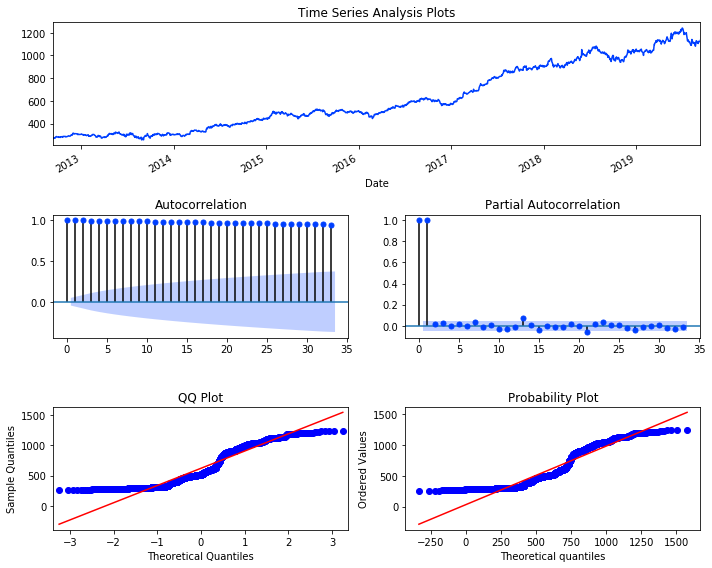

In [0]:
tsplot(my_stock.close)

# Checking for the stationarity

In [0]:
sTest = StationarityTests()
my_stock['daily_ret']=my_stock.close.pct_change(1)
sTest.ADF_Stationarity_Test(my_stock.daily_ret.dropna(), printResults = True)



####################################Augmented Dickey-Fuller Test Results:####################################
ADF Test Statistic       -32.558829
P-Value                    0.000000
# Lags Used                1.000000
# Observations Used     1715.000000
Critical Value (1%)       -3.434169
Critical Value (5%)       -2.863227
Critical Value (10%)      -2.567668
dtype: float64
Is the time series stationary? True
####################################KPSS Test Results:####################################
KPSS Test Statistic                                             0.040041
P-Value                                                              0.1
# Lags Used                                                           25
# Observations Used    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
Is the time series stationary? False


/home/jesvinsebastian/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [0]:
my_stock.head()
my_stock.drop('daily_ret',axis=1,inplace=True)
my_stock.head()

,close
Date,
2012-09-13,268.92
2012-09-14,275.01
2012-09-17,273.01
2012-09-18,271.73
2012-09-20,272.38


aic: 11682.34493 | order: (0, 1, 2)
Our residuals are likely not normally distributed.


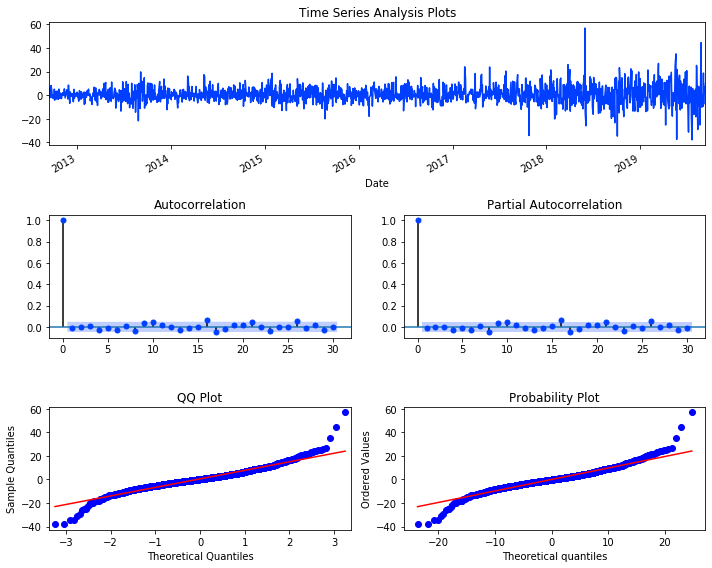

In [0]:

# Find the best ARIMA fit
res_tup = best_arima(my_stock)
order = res_tup[1]
model = res_tup[2]
    
    # Now that we have our ARIMA fit, we feed this to the GARCH model
p_ = order[0]
o_ = order[1]
q_ = order[2]

In [0]:
### Using the ARCH model function to model the volatility of the residuals
from arch import arch_model
vol_model = arch_model(model.resid)
res = vol_model.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 5628.210297656442
Iteration:     10,   Func. Count:     73,   Neg. LLF: 5619.466310170756
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5619.446694562095
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -5619.45
Distribution:                  Normal   AIC:                           11246.9
Method:            Maximum Likelihood   BIC:                           11268.7
                                        No. Observations:                 1717
Date:                Thu, Nov 14 2019   Df Residuals:                     1713
Time:         

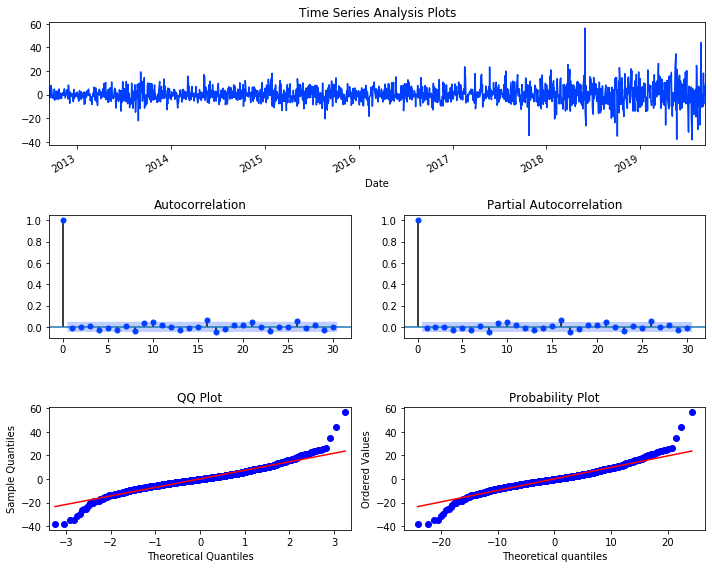

In [0]:
tsplot(res.resid, lags=30)

In [0]:
### Using the GARCH model to model the volatility of the residuals

am = arch_model(model.resid, p=1, o=1, q=1, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5578.27
Distribution:      Standardized Student's t   AIC:                           11168.5
Method:                  Maximum Likelihood   BIC:                           11201.2
                                              No. Observations:                 1717
Date:                      Thu, Nov 14 2019   Df Residuals:                     1711
Time:                              05:29:13   Df Model:                            6
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

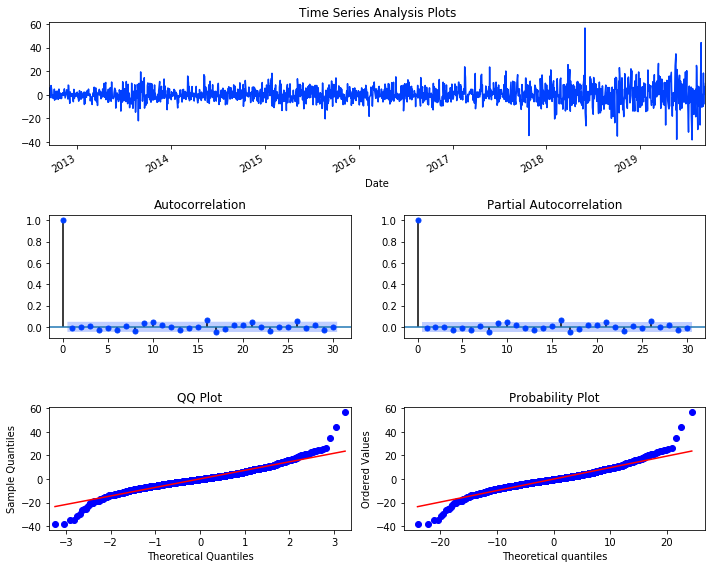

In [0]:
print(res.summary())
tsplot(res.resid, lags=30)

## imports the fitter function and produces estimated fits for our residuals

Fitted alpha distribution with error=0.0033045632798477716)
Fitted anglit distribution with error=0.03197437467789052)
Fitted arcsine distribution with error=0.048153942066630616)
Fitted argus distribution with error=0.038573950824798336)
Fitted beta distribution with error=0.0033834115107724233)
Fitted betaprime distribution with error=0.0037638973365395033)
Fitted bradford distribution with error=0.039263976500575754)
Fitted burr distribution with error=0.107952242403252)
Fitted burr12 distribution with error=0.0009954230668317052)
Fitted cauchy distribution with error=0.002284638900442401)
Fitted chi distribution with error=0.003405770724150429)
Fitted chi2 distribution with error=0.003694225876450838)
Fitted cosine distribution with error=0.027915323478934242)
Fitted crystalball distribution with error=0.002814987750153372)
Fitted dgamma distribution with error=0.0012097257178338336)
Fitted dweibull distribution with error=0.0009951578692516316)
Fitted erlang distribution with erro

,sumsquare_error
johnsonsu,0.000629


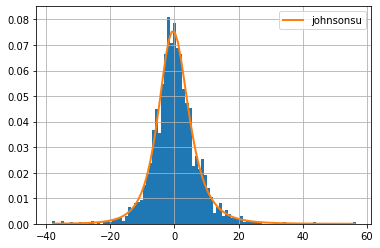

In [0]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the fitter function and produces estimated fits for our residuals
from fitter import Fitter

f = Fitter(res.resid)
f.fit()
f.summary(Nbest=1)
#f.get_best()

# Picking a Distribution for Predictions

In [0]:
# grabs the last 100 observations, which will be reduced to 50 for the purpose of fitting a
# distribution for Monte Carlo simulation
my_stock_resid_distr_fitting = my_stock[-500:]
# creates a training subset missing the final 100 observations, which are being withheld
my_stock_train = my_stock[~my_stock.isin(my_stock_resid_distr_fitting).all(1)]
# grabs the final 50 observations for a test set
my_stock_test = my_stock_resid_distr_fitting[-250:]
# reduces the distribution fitting dataset to 50 observations
my_stock_resid_distr_fitting = my_stock_resid_distr_fitting[~my_stock_resid_distr_fitting.isin(my_stock_test).all(1)]

In [0]:
print(len(my_stock),
      len(my_stock_resid_distr_fitting),
      len(my_stock_train),
      len(my_stock_test))

1718 250 1218 250


Test MSE: 384.998


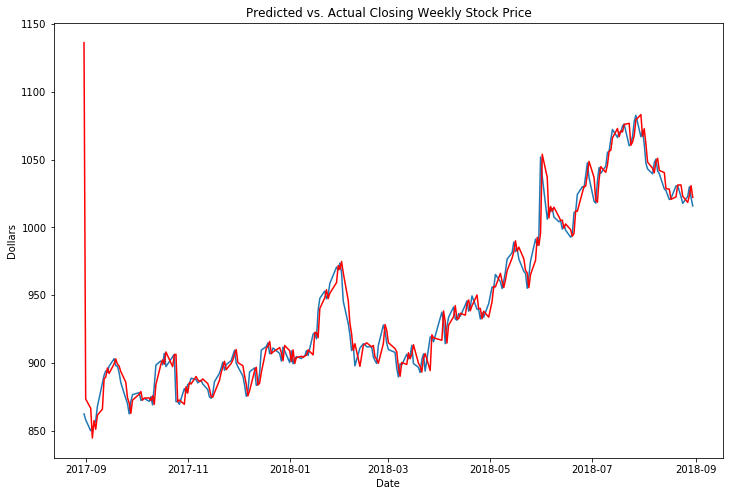

In [0]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the mean squared error function
from sklearn.metrics import mean_squared_error

# from https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

# creates a new dataframe that will be added to as the forecast rolls 
history = np.log(my_stock.astype(float))
# creates an empty list that will hold predictions
predictions = []
# loops through the indexes of the set being forecased
for i in range(len(my_stock_resid_distr_fitting)):
    # estimates an ARIMA model of order (1,1,1)
    model = smt.ARIMA(history, order = (1,1,1))
    # fits the model
    model_fit = model.fit(disp = 0)
    # forecasts the next period
    output = model_fit.forecast()
    # takes the predicted value and saves it in yhat
    yhat = np.e ** output[0]
    # appends yhat to the list of predictions
    predictions.append(yhat)
    # grabs the observation at the ith index
    obs = my_stock_resid_distr_fitting[i : i + 1]
    # appends the observation to the estimation data set
    history = history.append(np.log(obs.astype(float)))

# prints the MSE of the model for the rolling forecast period
error = mean_squared_error(my_stock_resid_distr_fitting, predictions)
print('Test MSE: %.3f' % error)

# converts the predictions list to a pandas dataframe with the same index as the actual values
# for plotting purposes
predictions = pd.DataFrame(predictions)
predictions.index = my_stock_resid_distr_fitting.index

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the predicted and actual stock prices 
plt.plot(my_stock_resid_distr_fitting)
plt.plot(predictions, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Predicted vs. Actual Closing Weekly Stock Price')
plt.show()

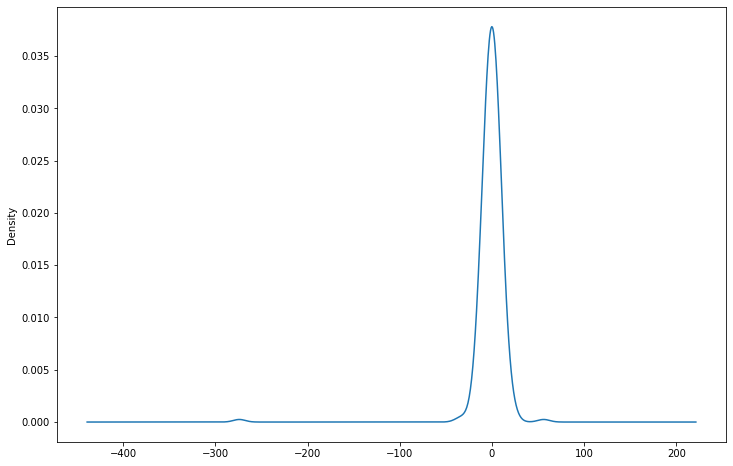

In [0]:

# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the residuals
tune_residuals = my_stock_resid_distr_fitting.close - predictions[0]
tune_residuals.plot(kind = 'kde')

In [0]:
# to suppress warnings
warnings.filterwarnings('ignore')

# produces a summary of the residuals
tune_residuals.astype(float).describe()

count    250.000000
mean      -1.181387
std       19.625045
min     -273.948453
25%       -5.798751
50%       -0.115223
75%        5.123497
max       56.122666
dtype: float64

# V. Using Monte Carlo Simulation to Predict Stock Price Intervals


In [0]:
# creates a function to do MC simulation with a Laplacian distribution
def laplace_monte_carlo(mean, residuals, n_sims):
    # gets the estimated beta or mean absolute distance from the mean
    beta = (sum(abs(residuals - np.mean(residuals))) 
                           / len(residuals))
    # uses the numpy function to generate an array of simulated values
    est_range = np.random.laplace(mean, beta, n_sims)
    # converts the array to a list
    est_range = list(est_range)
    # returns the simulated values
    return(est_range)

def roll_forecast_nmc(train, test, std_dev, n_sims):
    # creates a new dataframe that will be added to as the forecast rolls 
    history = np.log(train.astype(float))
    # creates an empty list that will hold predictions
    predictions = []
    # loops through the indexes of the set being forecased
    for i in range(len(test)):
        # estimates an ARIMA model of order (1,1,0)
        model = smt.ARIMA(history, order = (1,1,1))
        # fits the model
        model_fit = model.fit(disp = 0)
        # forecasts the next period
        output = model_fit.forecast()
        # takes the predicted value and saves it in yhat
        yhat = np.e ** output[0]
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        yhat_range = laplace_monte_carlo(yhat, std_dev, n_sims)
        # appends yhat_range to the list of predictions
        predictions.append([float(i) for i in yhat_range])
        # grabs the observation at the ith index
        obs = test[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(np.log(obs.astype(float)))

    # converts the predictions list to a pandas dataframe with the same index as the actual 
    # values for plotting purposes
    predictions = pd.DataFrame(predictions)
    predictions.index = my_stock_resid_distr_fitting.index
    # converts all the estimated yhats in each column to one list per row
    predictions['predicted_range'] = predictions.values.tolist()
    # grabs only the column with all values in a list
    predictions = pd.DataFrame(predictions['predicted_range'])
        
    # returns predictions
    return(predictions)

In [0]:

# attaches the data withheld for investigating the forecast residuals back to the training
# data set to avoid a large error on the first forecast
my_stock_train = my_stock_train.append(my_stock_resid_distr_fitting)


# produces a rolling forecast with prediction intervals using 1000 MC sims
test_preds = roll_forecast_nmc(my_stock_train, 
                               my_stock_test, 
                               tune_residuals,
                              1000)

In [0]:

# creates an empty list
in_prediction_interval = []
# loops through the rows in the testing data set
for i in range(len(my_stock_test)):
    # appends true if the actual price is in the interval of predicted prices and false
    # otherwise
    in_prediction_interval.append(np.where(min(test_preds.predicted_range[i]) <= 
                                           my_stock_test.close[i]
                                          <= max(test_preds.predicted_range[i]), 
                                           True, False))
# prints the percentage of actual prices in the prediction intervals    
print('Percentage of Actual Stock Prices in Predicted Stock Price Range: %f' % 
      (100 * sum(in_prediction_interval) / len(in_prediction_interval)))

Percentage of Actual Stock Prices in Predicted Stock Price Range: 100.000000


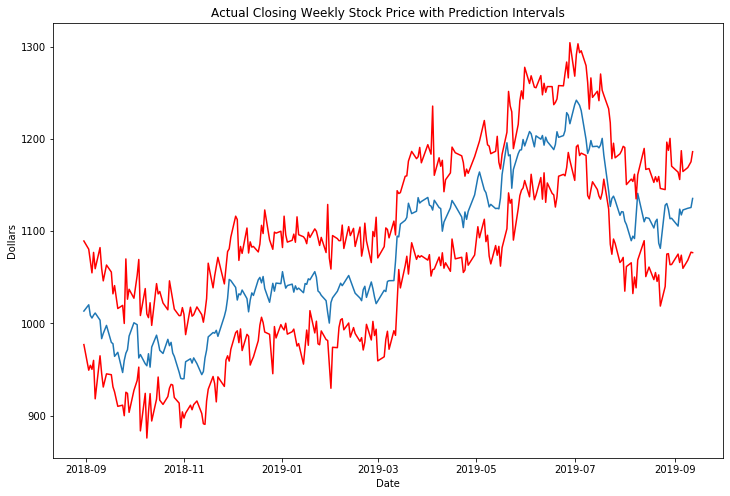

In [0]:

# creates empty lists to append to with minimum and maximum values for each weeks prediction
min_range = []
max_range = []

# loops through the rows in test_preds
for i in range(len(test_preds)):
    # appends to the list the min or max value as appropriate
    min_range.append(min(test_preds.predicted_range[i]))
    max_range.append(max(test_preds.predicted_range[i]))

# converts the lists to data frames and makes their indexes match up with the dates they're
# predicting
min_range = pd.DataFrame(min_range)
min_range.index = my_stock_test.index
max_range = pd.DataFrame(max_range)
max_range.index = my_stock_test.index

# plots the actual stock price with prediction intervals
plt.plot(my_stock_test)
plt.plot(min_range, color = 'red')
plt.plot(max_range, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Actual Closing Weekly Stock Price with Prediction Intervals')
plt.show()

In [0]:
len(my_stock_test)

250

In [0]:

# sets a target price to see the probability that the actual stock price is greater than or 
# equal to this target
target_price = 1135
# creates a list of True values where the simulated price is above or equal to the target price
# and False where it is below
above_target = [i >= target_price for i in test_preds.predicted_range[len(test_preds) - 1]]
# prints the probability
print('Probability Actual Stock Price is above Strike Price: %f' % 
      (sum(above_target) / len(above_target)))

Probability Actual Stock Price is above Strike Price: 0.193000
